In [44]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators.symplectic.pauli import Pauli
from qiskit.aqua.operators.legacy import WeightedPauliOperator

In [196]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

for dist in [2]:#distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

Interatomic Distance: 2 VQE Result: -7.860068380038318 Exact Energy: [-7.86015321]
All energies have been calculated


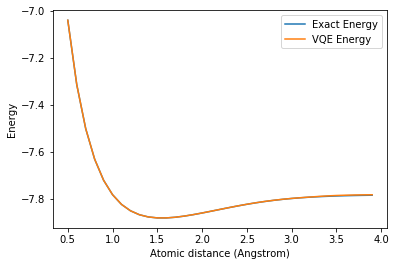

In [4]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [215]:
import cs_vqe as c
import copy

def construct_reduced_hamiltonian(ham, terms_noncon, num_qubits = 0, output_WPO = True) -> WeightedPauliOperator:
    """Determine reduced Hamiltonian on minimal contextual subset
    
    """
    #restructure WeightedPauliOperator ham from Qiskit list [[complex, Pauli]] -> dict {str:complex}
    if str(type(ham)) == "<class 'qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator'>":
        Paulis = ham.paulis
        ham = {(p[1]).to_label():p[0] for p in Paulis}
        
    #Leave if already in correct format
    elif str(type(ham)) == "<class 'dict'>":
        pass
    
    #Reserved for alternative formats
    else:
        raise Exception("Unrecognised Hamiltonian Format")
            
    #Find largest noncontextual subset
    #terms_noncon = c.greedy_dfs(ham, 10, criterion='weight')[-1]
    ham_noncon = {p:ham[p] for p in terms_noncon}
    
    #Contrusct epistricted model
    model = c.quasi_model(ham_noncon)
    fn_form = c.energy_function_form(ham_noncon, model)
    gs_noncon = c.find_gs_noncon(ham_noncon)
    ep_state = gs_noncon[1]
    
    #Determine contextual subspace Hamiltonians
    order = list(range(len(model[0][0]))) #this can be user-specified in future
    order_ref = copy.deepcopy(order) #since get_reduced_hamiltonians empties original order
    reduced_hamiltonians = c.get_reduced_hamiltonians(ham, model, fn_form, ep_state, order)
    red_ham = reduced_hamiltonians[num_qubits]
    
    if output_WPO == True:
        return WeightedPauliOperator([[red_ham[k], Pauli(k)] for k in red_ham.keys()]), gs_noncon[0]
    else:
        return red_ham, gs_noncon[0]

In [219]:
def CS_VQE(ham, terms_noncon, num_qubits, num_orbitals, num_particles, shift=0, 
           backend=BasicAer.get_backend("statevector_simulator"), optimizer = SLSQP(maxiter=20)):
    """
    """
    red_ham, gs_approx = construct_reduced_hamiltonian(ham, terms_noncon, num_qubits)

    initial_state = HartreeFock(
        num_orbitals=num_orbitals,
        num_particles=num_particles,
        qubit_mapping='parity')
    #print(initial_state.construct_circuit(mode='vector'))
    
    var_form = UCCSD(
        num_orbitals=num_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity')
    
    vqe = VQE(red_ham, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue']) + shift
    
    return vqe_result

In [214]:
pre_ham = {(p[1]).to_label():p[0] for p in get_qubit_op(1)[0].paulis}
terms_noncon = (c.greedy_dfs(pre_ham, 10, criterion='weight'))[-1]
terms_noncon

['IIZI',
 'ZIII',
 'IIII',
 'IIZZ',
 'ZZII',
 'IZIZ',
 'ZIIZ',
 'IZZI',
 'ZIZI',
 'IIIZ',
 'IZII',
 'ZZZZ',
 'ZZIZ',
 'IZZZ',
 'ZIZZ',
 'ZZZI',
 'IZXX',
 'IZYY',
 'ZIXX',
 'ZIYY',
 'ZZXX',
 'ZZYY',
 'IIXX',
 'IIYY']

In [223]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

distances = np.arange(0.5, 4, 0.1)
exact_energies = []
vqe_energies = []

for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    
    vqe_result = CS_VQE(qubitOp, terms_noncon, 4, num_spin_orbitals, num_particles, shift=shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.031351025624939 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.3013112076428754 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.486249065044777 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.61459809317051 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.705828324548403 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.767420034384079 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.8087446962414155 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.83567404393764 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.852608262673456 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.86150664190578 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.864950880257563 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.8645888001385345 Exact Ene

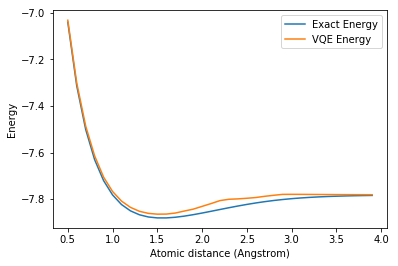

In [224]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [144]:
construct_reduced_hamiltonian(qubitOp, 3)

(<qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator at 0x7fba368407f0>,
 -7.830905584637077)

In [26]:
n_qubits = 4
true_gs = -7.86015321
order = [0, 1, 2, 3]

csvqe = c.csvqe_approximations_heuristic(ham, ham_noncon, n_qubits, true_gs)
print(c.contextual_subspace_approximations(ham, model, fn_form, ep_state, order))

print('true ground state energy:', csvqe[0], '\n')
print('CS-VQE approximations:', [c+shift for c in csvqe[1]], '\n')
print('CS-VQE errors:', [csvqe[2]+shift], '\n')
print('chosen order:', csvqe[3])

[-0.960490906211567, -0.96049094, -0.9604912, -0.9668129, -0.989739]
true ground state energy: -7.86015321 

CS-VQE approximations: [-7.830905584637077, -7.830905560822208, -7.834841911167819, -7.855121795506198, -7.860153321594913] 

CS-VQE errors: [array([ 2.92476254e-02,  2.92476492e-02,  2.53112988e-02,  5.03141449e-03,
       -1.11594913e-07])] 

chosen order: [1, 3, 0, 2]


In [107]:
red_ham = reduced_hamiltonians[4]
reconstruct_Qham = WeightedPauliOperator([[red_ham[k], Pauli(k)] for k in red_ham.keys()])
reconstruct_Qham.num_qubits

4

In [108]:
initial_state = HartreeFock(
        num_orbitals=6,
        num_particles=2,
        qubit_mapping='parity')
print(initial_state.construct_circuit(mode='vector'))
var_form = UCCSD(
        num_orbitals=6,
        num_particles=2,
        initial_state=initial_state,
        qubit_mapping='parity')
print(var_form.construct_circuit([0,0,0,0,0,0,0,0]))
vqe = VQE(reconstruct_Qham, var_form, optimizer)
vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     ┌───┐┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
q_0: ┤ X ├┤0             ├┤0             ├┤0             ├┤0             ├»
     ├───┤│              ││              ││              ││              │»
q_1: ┤ X ├┤1             ├┤1             ├┤1             ├┤1             ├»
     └───┘│  Evolution^1 ││  Evolution^1 ││  Evolution^1 ││  Evolution^1 │»
q_2: ─────┤2             ├┤2             ├┤2             ├┤2             ├»
          │              ││              ││              ││              │»
q_3: ─────┤3             ├┤3             ├┤3             ├┤3             ├»
          └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«     ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐
«q_0: ┤0             ├┤0             ├┤0             ├┤0             ├
«     │              ││              ││              ││              │
«q_1: ┤1             ├┤1             ├┤1             

In [109]:
vqe_result

-7.699323240312931

In [130]:
str(type(qubitOp))

"<class 'qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator'>"

In [133]:
str(type({p:ham[p] for p in terms_noncon}))

"<class 'dict'>"